<a href="https://colab.research.google.com/github/anpham1331372/ECGR5106/blob/main/ECGR5106_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1, Training Loss: 4.7536, Validation Loss: 3.7255, Validation Accuracy: 0.2350
Epoch 2, Training Loss: 3.5855, Validation Loss: 2.7710, Validation Accuracy: 0.3794
Epoch 3, Training Loss: 2.7431, Validation Loss: 1.9051, Validation Accuracy: 0.5177
Epoch 4, Training Loss: 2.0110, Validation Loss: 1.3328, Validation Accuracy: 0.7235
Epoch 5, Training Loss: 1.4349, Validation Loss: 0.8817, Validation Accuracy: 0.8095
Epoch 6, Training Loss: 1.0107, Validation Loss: 0.6356, Validation Accuracy: 0.8602
Epoch 7, Training Loss: 0.7412, Validation Loss: 0.4493, Validation Accuracy: 0.9155
Epoch 8, Training Loss: 0.5474, Validation Loss: 0.3229, Validation Accuracy: 0.9508
Epoch 9, Training Loss: 0.3789, Validation Loss: 0.2255, Validation Accuracy: 0.9708
Epoch 10, Training Loss: 0.2688, Validation Loss: 0.1504, Validation Accuracy: 0.9831
Epoch 11, Training Loss: 0.1747, Validation Loss: 0.0961, Validation Accuracy: 0.9969
Epoch 12, Training Loss: 0.1103, Validation Loss: 0.0637, Valid

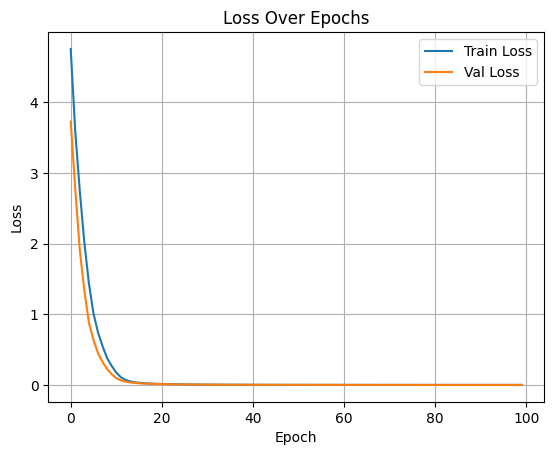

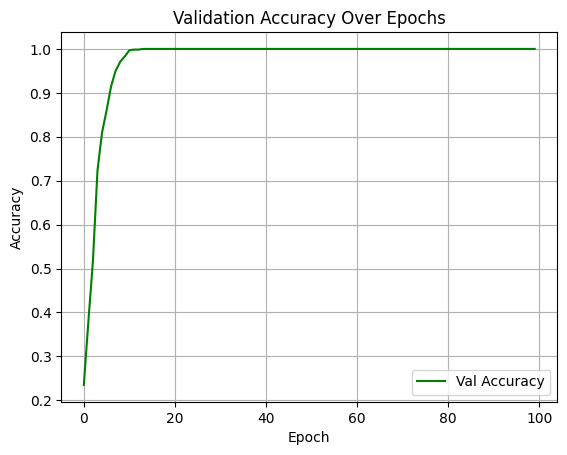

He is hungry -> Il a faim
She speaks French fluently -> Elle parle français couramment
The sun is shining -> Le soleil brille

--- Qualitative Evaluation on Recombinations ---
She is hungry → Elle est heureuse
We are tired → Nous célébrons les anniversaires avec un gâteau
They love music → Ils boivent du café le matin
He speaks French → Il écoute de la musique en faisant du jogging
The cat is happy → Le chat miaule bruyamment
He studies mathematics → Il étudie dur pour les examens
We watch movies together → Nous regardons des films le vendredi
She plays soccer → Elle écrit de la poésie pendant son temps libre


In [22]:
#Problem 1
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Vocabulary Class ---
class Vocabulary:
    def __init__(self):
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>"}
        self.word_count = {}
        self.n_words = 3

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word_count[word] = 1
            self.n_words += 1
        else:
            self.word_count[word] += 1

# --- Dataset and Tokenization ---
def tokenize_and_pad(sentences, vocab):
    max_length = max(len(sentence.split(' ')) for sentence in sentences) + 2
    tokenized = []
    for sentence in sentences:
        tokens = [vocab.word2index["<SOS>"]] + [vocab.word2index[word] for word in sentence.split(' ')] + [vocab.word2index["<EOS>"]]
        tokens += [vocab.word2index["<PAD>"]] * (max_length - len(tokens))
        tokenized.append(tokens)
    return torch.tensor(tokenized, dtype=torch.long)

class EngFrDataset(Dataset):
    def __init__(self, pairs):
        self.eng_vocab = Vocabulary()
        self.fr_vocab = Vocabulary()
        self.pairs = pairs

        for eng, fr in pairs:
            self.eng_vocab.add_sentence(eng)
            self.fr_vocab.add_sentence(fr)

        self.eng_sentences = [pair[0] for pair in pairs]
        self.fr_sentences = [pair[1] for pair in pairs]
        self.eng_tokens = tokenize_and_pad(self.eng_sentences, self.eng_vocab)
        self.fr_tokens = tokenize_and_pad(self.fr_sentences, self.fr_vocab)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.eng_tokens[idx], self.fr_tokens[idx]

# --- GRU Encoder and Decoder ---
class GRUEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        _, hidden = self.gru(embedded)
        return hidden

class GRUDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded, hidden)
        output = self.softmax(self.fc(output))
        return output, hidden

# --- Training Function ---
def train_model(encoder, decoder, dataloader, fr_vocab, n_epochs=20):
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
    criterion = nn.NLLLoss(ignore_index=fr_vocab.word2index["<PAD>"])

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(n_epochs):
        encoder.train()
        decoder.train()

        total_loss = 0
        for eng_tensor, fr_tensor in dataloader:
            eng_tensor, fr_tensor = eng_tensor.to(device), fr_tensor.to(device)
            encoder_hidden = encoder(eng_tensor)
            decoder_input = fr_tensor[:, :-1]
            decoder_target = fr_tensor[:, 1:]
            decoder_output, _ = decoder(decoder_input, encoder_hidden)

            loss = criterion(decoder_output.view(-1, decoder_output.size(-1)), decoder_target.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)

        # Switch to eval to compute validation metrics
        val_loss, val_acc = evaluate_model(encoder, decoder, dataloader, fr_vocab, verbose=False)

        # Restore training mode
        encoder.train()
        decoder.train()

        train_losses.append(avg_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    return train_losses, val_losses, val_accuracies

# --- Evaluation Function ---
def evaluate_model(encoder, decoder, dataloader, fr_vocab, verbose=True):
    encoder.eval()
    decoder.eval()
    criterion = nn.NLLLoss(ignore_index=fr_vocab.word2index["<PAD>"])
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for eng_tensor, fr_tensor in dataloader:
            eng_tensor, fr_tensor = eng_tensor.to(device), fr_tensor.to(device)
            encoder_hidden = encoder(eng_tensor)
            decoder_input = fr_tensor[:, :-1]
            decoder_target = fr_tensor[:, 1:]
            decoder_output, _ = decoder(decoder_input, encoder_hidden)

            loss = criterion(decoder_output.view(-1, decoder_output.size(-1)), decoder_target.view(-1))
            total_loss += loss.item()

            predictions = decoder_output.argmax(dim=2)
            mask = decoder_target != fr_vocab.word2index["<PAD>"]
            correct += ((predictions == decoder_target) & mask).sum().item()
            total += mask.sum().item()

    val_loss = total_loss / len(dataloader)
    val_acc = correct / total
    if verbose:
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}")
    return val_loss, val_acc

# --- Translation ---
def translate(encoder, decoder, sentence, dataset):
    encoder.eval()
    decoder.eval()
    eng_vocab = dataset.eng_vocab
    fr_vocab = dataset.fr_vocab

    tokens = [eng_vocab.word2index.get("<SOS>", 1)] + [eng_vocab.word2index.get(word, 0) for word in sentence.split()] + [eng_vocab.word2index.get("<EOS>", 2)]
    input_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        hidden = encoder(input_tensor)
        decoder_input = torch.tensor([[fr_vocab.word2index["<SOS>"]]], device=device)
        decoded_words = []

        for _ in range(20):
            output, hidden = decoder(decoder_input, hidden)
            topv, topi = output.topk(1)
            next_word = topi[:, 0, 0].item()
            if next_word == fr_vocab.word2index["<EOS>"]:
                break
            decoded_words.append(fr_vocab.index2word[next_word])
            decoder_input = torch.tensor([[next_word]], device=device)

    return ' '.join(decoded_words)

# --- Dataset ---
english_to_french = [
    ("I am cold", "J'ai froid"),
    ("You are tired", "Tu es fatigué"),
    ("He is hungry", "Il a faim"),
    ("She is happy", "Elle est heureuse"),
    ("We are friends", "Nous sommes amis"),
    ("They are students", "Ils sont étudiants"),
    ("The cat is sleeping", "Le chat dort"),
    ("The sun is shining", "Le soleil brille"),
    ("We love music", "Nous aimons la musique"),
    ("She speaks French fluently", "Elle parle français couramment"),
    ("He enjoys reading books", "Il aime lire des livres"),
    ("They play soccer every weekend", "Ils jouent au football chaque week-end"),
    ("The movie starts at 7 PM", "Le film commence à 19 heures"),
    ("She wears a red dress", "Elle porte une robe rouge"),
    ("We cook dinner together", "Nous cuisinons le dîner ensemble"),
    ("He drives a blue car", "Il conduit une voiture bleue"),
    ("They visit museums often", "Ils visitent souvent des musées"),
    ("The restaurant serves delicious food", "Le restaurant sert une délicieuse cuisine"),
    ("She studies mathematics at university", "Elle étudie les mathématiques à l'université"),
    ("We watch movies on Fridays", "Nous regardons des films le vendredi"),
("He listens to music while jogging", "Il écoute de la musique en faisant du jogging"),
("They travel around the world", "Ils voyagent autour du monde"),
("The book is on the table", "Le livre est sur la table"),
("She dances gracefully", "Elle danse avec grâce"),
("We celebrate birthdays with cake", "Nous célébrons les anniversaires avec un gâteau"),
("He works hard every day", "Il travaille dur tous les jours"),
("They speak different languages", "Ils parlent différentes langues"),
("The flowers bloom in spring", "Les fleurs fleurissent au printemps"),
("She writes poetry in her free time", "Elle écrit de la poésie pendant son temps libre"),
("We learn something new every day", "Nous apprenons quelque chose de nouveau chaque jour"),
("The dog barks loudly", "Le chien aboie bruyamment"),
("He sings beautifully", "Il chante magnifiquement"),
("They swim in the pool", "Ils nagent dans la piscine"),
("The birds chirp in the morning", "Les oiseaux gazouillent le matin"),
("She teaches English at school", "Elle enseigne l'anglais à l'école"),
("We eat breakfast together", "Nous prenons le petit déjeuner ensemble"),
("He paints landscapes", "Il peint des paysages"),
("They laugh at the joke", "Ils rient de la blague"),
("The clock ticks loudly", "L'horloge tic-tac bruyamment"),
("She runs in the park", "Elle court dans le parc"),
("We travel by train", "Nous voyageons en train"),
("He writes a letter", "Il écrit une lettre"),
("They read books at the library", "Ils lisent des livres à la bibliothèque"),
("The baby cries", "Le bébé pleure"),
("She studies hard for exams", "Elle étudie dur pour les examens"),
("We plant flowers in the garden", "Nous plantons des fleurs dans le jardin"),
("He fixes the car", "Il répare la voiture"),
("They drink coffee in the morning", "Ils boivent du café le matin"),
("The sun sets in the evening", "Le soleil se couche le soir"),
("She dances at the party", "Elle danse à la fête"),
("We play music at the concert", "Nous jouons de la musique au concert"),
("He cooks dinner for his family", "Il cuisine le dîner pour sa famille"),
("They study French grammar", "Ils étudient la grammaire française"),
("The rain falls gently", "La pluie tombe doucement"),
("She sings a song", "Elle chante une chanson"),
("We watch a movie together", "Nous regardons un film ensemble"),
("He sleeps deeply", "Il dort profondément"),
("They travel to Paris", "Ils voyagent à Paris"),
("The children play in the park", "Les enfants jouent dans le parc"),
("She walks along the beach", "Elle se promène le long de la plage"),
("We talk on the phone", "Nous parlons au téléphone"),
("He waits for the bus", "Il attend le bus"),
("They visit the Eiffel Tower", "Ils visitent la tour Eiffel"),
("The stars twinkle at night", "Les étoiles scintillent la nuit"),
("She dreams of flying", "Elle rêve de voler"),
("We work in the office", "Nous travaillons au bureau"),
("He studies history", "Il étudie l'histoire"),
("They listen to the radio", "Ils écoutent la radio"),
("The wind blows gently", "Le vent souffle doucement"),
("She swims in the ocean", "Elle nage dans l'océan"),
("We dance at the wedding", "Nous dansons au mariage"),
("He climbs the mountain", "Il gravit la montagne"),
("They hike in the forest", "Ils font de la randonnée dans la forêt"),
("The cat meows loudly", "Le chat miaule bruyamment"),
("She paints a picture", "Elle peint un tableau"),
("We build a sandcastle", "Nous construisons un château de sable"),
("He sings in the choir", "Il chante dans le chœur"),
("They ride bicycles", "Ils font du vélo"),
("The coffee is hot", "Le café est chaud"),
("She wears glasses", "Elle porte des lunettes"),
("We visit our grandparents", "Nous rendons visite à nos grands-parents"),
("He plays the guitar", "Il joue de la guitare"),
("They go shopping", "Ils font du shopping"),
("The teacher explains the lesson", "Le professeur explique la leçon"),
("She takes the train to work", "Elle prend le train pour aller au travail"),
("We bake cookies", "Nous faisons des biscuits"),
("He washes his hands", "Il se lave les mains"),
("They enjoy the sunset", "Ils apprécient le coucher du soleil"),
("The river flows calmly", "La rivière coule calmement"),
("She feeds the cat", "Elle nourrit le chat"),
("We visit the museum", "Nous visitons le musée"),
("He fixes his bicycle", "Il répare son vélo"),
("They paint the walls", "Ils peignent les murs"),
("The baby sleeps peacefully", "Le bébé dort paisiblement"),
("She ties her shoelaces", "Elle attache ses lacets"),
("We climb the stairs", "Nous montons les escaliers"),
("He shaves in the morning", "Il se rase le matin"),
("They set the table", "Ils mettent la table"),
("The airplane takes off", "L'avion décolle"),
("She waters the plants", "Elle arrose les plantes"),
("We practice yoga", "Nous pratiquons le yoga"),
("He turns off the light", "Il éteint la lumière"),
("They play video games", "Ils jouent aux jeux vidéo"),
("The soup smells delicious", "La soupe sent délicieusement bon"),
("She locks the door", "Elle ferme la porte à clé"),
("We enjoy a picnic", "Nous profitons d'un pique-nique"),
("He checks his email", "Il vérifie ses emails"),
("They go to the gym", "Ils vont à la salle de sport"),
("The moon shines brightly", "La lune brille intensément"),
("She catches the bus", "Elle attrape le bus"),
("We greet our neighbors", "Nous saluons nos voisins"),
("He combs his hair", "Il se peigne les cheveux"),
("They wave goodbye", "Ils font un signe d'adieu")
]

# Dataloader
dataset = EngFrDataset(english_to_french)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Instantiate models
encoder = GRUEncoder(input_dim=dataset.eng_vocab.n_words, emb_dim=100, hid_dim=256).to(device)
decoder = GRUDecoder(output_dim=dataset.fr_vocab.n_words, emb_dim=100, hid_dim=256).to(device)

# Train
train_losses, val_losses, val_accuracies = train_model(encoder, decoder, dataloader, dataset.fr_vocab, n_epochs=100)

# Plot Losses
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure()
plt.plot(val_accuracies, label='Val Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Translate examples
examples = ["He is hungry", "She speaks French fluently", "The sun is shining"] #exmaples from known sentences
for sent in examples:
    print(f"{sent} -> {translate(encoder, decoder, sent, dataset)}")


recombinations = [
    "She is hungry",              # combines "She is happy" + "He is hungry"
    "We are tired",               # "We are friends" + "You are tired"
    "They love music",            # "We love music" + "They play soccer"
    "He speaks French",           # simpler version of "She speaks French fluently"
    "The cat is happy",           # "The cat is sleeping" + "She is happy"
    "He studies mathematics",     # shortened version of a real example
    "We watch movies together",   # combo of "We watch movies on Fridays" + "We cook dinner together"
    "She plays soccer",           # not directly in dataset, but uses known words
]

print("\n--- Qualitative Evaluation on Recombinations ---")
for sent in recombinations:
    translation = translate(encoder, decoder, sent, dataset)
    print(f"{sent} → {translation}")


Epoch 1, Train Loss: 4.5834, Val Loss: 3.9102, Val Accuracy: 0.2258
Epoch 2, Train Loss: 3.8197, Val Loss: 3.1565, Val Accuracy: 0.2980
Epoch 3, Train Loss: 3.0851, Val Loss: 2.3054, Val Accuracy: 0.4885
Epoch 4, Train Loss: 2.4059, Val Loss: 1.6441, Val Accuracy: 0.6375
Epoch 5, Train Loss: 1.7783, Val Loss: 1.0861, Val Accuracy: 0.7911
Epoch 6, Train Loss: 1.2363, Val Loss: 0.7183, Val Accuracy: 0.8618
Epoch 7, Train Loss: 0.8048, Val Loss: 0.4199, Val Accuracy: 0.9432
Epoch 8, Train Loss: 0.5221, Val Loss: 0.2627, Val Accuracy: 0.9800
Epoch 9, Train Loss: 0.3081, Val Loss: 0.1636, Val Accuracy: 0.9923
Epoch 10, Train Loss: 0.1908, Val Loss: 0.1040, Val Accuracy: 0.9939
Epoch 11, Train Loss: 0.1242, Val Loss: 0.0686, Val Accuracy: 0.9985
Epoch 12, Train Loss: 0.0746, Val Loss: 0.0441, Val Accuracy: 1.0000
Epoch 13, Train Loss: 0.0506, Val Loss: 0.0338, Val Accuracy: 1.0000
Epoch 14, Train Loss: 0.0386, Val Loss: 0.0268, Val Accuracy: 1.0000
Epoch 15, Train Loss: 0.0304, Val Loss: 0.0

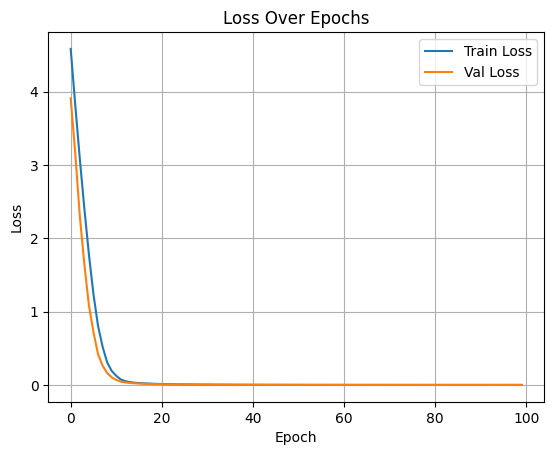

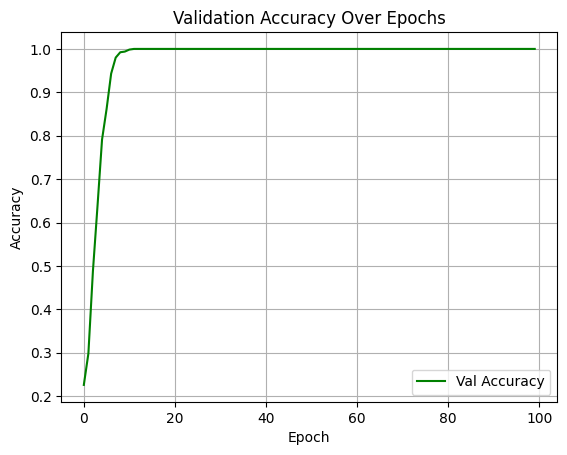


--- Known Sentences ---
He is hungry -> Il a la voiture
She speaks French fluently -> Elle parle français couramment de nouveau
The sun is shining -> Le soleil brille le soir

--- Recombinations ---
She is hungry -> Elle est heureuse à l'université
We are tired -> Nous apprenons quelque chose de nouveau
They love music -> Ils lisent des livres à la bibliothèque
He speaks French -> Il cuisine le dîner pour sa famille
The cat is happy -> Le chat dort


In [35]:
#Problem 2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Vocabulary ---
class Vocabulary:
    def __init__(self):
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>"}
        self.word_count = {}
        self.n_words = 3

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word_count[word] = 1
            self.n_words += 1
        else:
            self.word_count[word] += 1

# --- Tokenization ---
def tokenize_and_pad(sentences, vocab):
    max_length = max(len(sentence.split(' ')) for sentence in sentences) + 2
    tokenized = []
    for sentence in sentences:
        tokens = [vocab.word2index["<SOS>"]] + [vocab.word2index[word] for word in sentence.split(' ')] + [vocab.word2index["<EOS>"]]
        tokens += [vocab.word2index["<PAD>"]] * (max_length - len(tokens))
        tokenized.append(tokens)
    return torch.tensor(tokenized, dtype=torch.long)

# --- Dataset ---
class EngFrDataset(Dataset):
    def __init__(self, pairs):
        self.eng_vocab = Vocabulary()
        self.fr_vocab = Vocabulary()
        self.pairs = pairs

        for eng, fr in pairs:
            self.eng_vocab.add_sentence(eng)
            self.fr_vocab.add_sentence(fr)

        self.eng_sentences = [pair[0] for pair in pairs]
        self.fr_sentences = [pair[1] for pair in pairs]
        self.eng_tokens = tokenize_and_pad(self.eng_sentences, self.eng_vocab)
        self.fr_tokens = tokenize_and_pad(self.fr_sentences, self.fr_vocab)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.eng_tokens[idx], self.fr_tokens[idx]

# --- Encoder ---
class GRUEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden

# --- Decoder with Bahdanau-style attention ---
class AttnDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout_p=0.1):
        super(AttnDecoder, self).__init__()
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.attn = nn.Linear(hid_dim + emb_dim, hid_dim)
        self.v = nn.Parameter(torch.rand(hid_dim))
        self.attn_combine = nn.Linear(hid_dim + emb_dim, hid_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hid_dim, hid_dim)
        self.out = nn.Linear(hid_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)  # [B, 1, E]
        embedded = self.dropout(embedded)

        batch_size = encoder_outputs.size(0)
        seq_len = encoder_outputs.size(1)

        hidden_trans = hidden.transpose(0, 1)  # [B, 1, H]
        hidden_repeat = hidden_trans.repeat(1, seq_len, 1)
        embedded_repeat = embedded.repeat(1, seq_len, 1)

        attn_input = torch.cat((embedded_repeat, hidden_repeat), dim=2)  # [B, T, H+E]
        energy = torch.tanh(self.attn(attn_input))  # [B, T, H]
        energy = torch.sum(self.v * energy, dim=2)  # [B, T]
        attn_weights = torch.softmax(energy, dim=1)  # [B, T]

        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # [B, 1, H]
        rnn_input = torch.cat((embedded, context), dim=2)  # [B, 1, E+H]
        rnn_input = torch.relu(self.attn_combine(rnn_input))  # [B, 1, H]

        output, hidden = self.gru(rnn_input, hidden)
        output = torch.log_softmax(self.out(output), dim=2)  # [B, 1, V]
        return output, hidden

# --- Training ---
def train_model(encoder, decoder, dataloader, fr_vocab, n_epochs=20):
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
    criterion = nn.NLLLoss(ignore_index=fr_vocab.word2index["<PAD>"])
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(n_epochs):
        encoder.train()
        decoder.train()
        total_loss = 0

        for eng_tensor, fr_tensor in dataloader:
            eng_tensor, fr_tensor = eng_tensor.to(device), fr_tensor.to(device)
            encoder_outputs, encoder_hidden = encoder(eng_tensor)
            decoder_input = fr_tensor[:, :-1]
            decoder_target = fr_tensor[:, 1:]

            decoder_outputs = []
            decoder_hidden = encoder_hidden

            for t in range(decoder_input.size(1)):
                output, decoder_hidden = decoder(decoder_input[:, t].unsqueeze(1), decoder_hidden, encoder_outputs)
                decoder_outputs.append(output)

            decoder_outputs = torch.cat(decoder_outputs, dim=1)
            loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), decoder_target.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        val_loss, val_acc = evaluate_model(encoder, decoder, dataloader, fr_vocab, verbose=False)
        train_losses.append(avg_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    return train_losses, val_losses, val_accuracies

# --- Evaluation ---
def evaluate_model(encoder, decoder, dataloader, fr_vocab, verbose=True):
    encoder.eval()
    decoder.eval()
    criterion = nn.NLLLoss(ignore_index=fr_vocab.word2index["<PAD>"])
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for eng_tensor, fr_tensor in dataloader:
            eng_tensor, fr_tensor = eng_tensor.to(device), fr_tensor.to(device)
            encoder_outputs, encoder_hidden = encoder(eng_tensor)
            decoder_input = fr_tensor[:, :-1]
            decoder_target = fr_tensor[:, 1:]

            decoder_outputs = []
            decoder_hidden = encoder_hidden

            for t in range(decoder_input.size(1)):
                output, decoder_hidden = decoder(decoder_input[:, t].unsqueeze(1), decoder_hidden, encoder_outputs)
                decoder_outputs.append(output)

            decoder_outputs = torch.cat(decoder_outputs, dim=1)
            loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), decoder_target.view(-1))
            total_loss += loss.item()

            predictions = decoder_outputs.argmax(dim=2)
            mask = decoder_target != fr_vocab.word2index["<PAD>"]
            correct += ((predictions == decoder_target) & mask).sum().item()
            total += mask.sum().item()

    val_loss = total_loss / len(dataloader)
    val_acc = correct / total
    if verbose:
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}")
    return val_loss, val_acc

# --- Translate ---
def translate(encoder, decoder, sentence, dataset):
    encoder.eval()
    decoder.eval()
    eng_vocab = dataset.eng_vocab
    fr_vocab = dataset.fr_vocab
    tokens = [eng_vocab.word2index.get("<SOS>", 1)] + [eng_vocab.word2index.get(word, 0) for word in sentence.split()] + [eng_vocab.word2index.get("<EOS>", 2)]
    input_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_input = torch.tensor([[fr_vocab.word2index["<SOS>"]]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []

        for _ in range(20):
            output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = output.topk(1)
            next_word = topi[:, 0, 0].item()
            if next_word == fr_vocab.word2index["<EOS>"]:
                break
            decoded_words.append(fr_vocab.index2word[next_word])
            decoder_input = torch.tensor([[next_word]], device=device)

    return ' '.join(decoded_words)

# --- Sample Dataset ---
english_to_french = [
    ("I am cold", "J'ai froid"),
    ("You are tired", "Tu es fatigué"),
    ("He is hungry", "Il a faim"),
    ("She is happy", "Elle est heureuse"),
    ("We are friends", "Nous sommes amis"),
    ("They are students", "Ils sont étudiants"),
    ("The cat is sleeping", "Le chat dort"),
    ("The sun is shining", "Le soleil brille"),
    ("We love music", "Nous aimons la musique"),
    ("She speaks French fluently", "Elle parle français couramment"),
    ("He enjoys reading books", "Il aime lire des livres"),
("They play soccer every weekend", "Ils jouent au football chaque week-end"),
("The movie starts at 7 PM", "Le film commence à 19 heures"),
("She wears a red dress", "Elle porte une robe rouge"),
("We cook dinner together", "Nous cuisinons le dîner ensemble"),
("He drives a blue car", "Il conduit une voiture bleue"),
("They visit museums often", "Ils visitent souvent des musées"),
("The restaurant serves delicious food", "Le restaurant sert une délicieuse cuisine"),
("She studies mathematics at university", "Elle étudie les mathématiques à l'université"),
("We watch movies on Fridays", "Nous regardons des films le vendredi"),
("He listens to music while jogging", "Il écoute de la musique en faisant du jogging"),
("They travel around the world", "Ils voyagent autour du monde"),
("The book is on the table", "Le livre est sur la table"),
("She dances gracefully", "Elle danse avec grâce"),
("We celebrate birthdays with cake", "Nous célébrons les anniversaires avec un gâteau"),
("He works hard every day", "Il travaille dur tous les jours"),
("They speak different languages", "Ils parlent différentes langues"),
("The flowers bloom in spring", "Les fleurs fleurissent au printemps"),
("She writes poetry in her free time", "Elle écrit de la poésie pendant son temps libre"),
("We learn something new every day", "Nous apprenons quelque chose de nouveau chaque jour"),
("The dog barks loudly", "Le chien aboie bruyamment"),
("He sings beautifully", "Il chante magnifiquement"),
("They swim in the pool", "Ils nagent dans la piscine"),
("The birds chirp in the morning", "Les oiseaux gazouillent le matin"),
("She teaches English at school", "Elle enseigne l'anglais à l'école"),
("We eat breakfast together", "Nous prenons le petit déjeuner ensemble"),
("He paints landscapes", "Il peint des paysages"),
("They laugh at the joke", "Ils rient de la blague"),
("The clock ticks loudly", "L'horloge tic-tac bruyamment"),
("She runs in the park", "Elle court dans le parc"),
("We travel by train", "Nous voyageons en train"),
("He writes a letter", "Il écrit une lettre"),
("They read books at the library", "Ils lisent des livres à la bibliothèque"),
("The baby cries", "Le bébé pleure"),
("She studies hard for exams", "Elle étudie dur pour les examens"),
("We plant flowers in the garden", "Nous plantons des fleurs dans le jardin"),
("He fixes the car", "Il répare la voiture"),
("They drink coffee in the morning", "Ils boivent du café le matin"),
("The sun sets in the evening", "Le soleil se couche le soir"),
("She dances at the party", "Elle danse à la fête"),
("We play music at the concert", "Nous jouons de la musique au concert"),
("He cooks dinner for his family", "Il cuisine le dîner pour sa famille"),
("They study French grammar", "Ils étudient la grammaire française"),
("The rain falls gently", "La pluie tombe doucement"),
("She sings a song", "Elle chante une chanson"),
("We watch a movie together", "Nous regardons un film ensemble"),
("He sleeps deeply", "Il dort profondément"),
("They travel to Paris", "Ils voyagent à Paris"),
("The children play in the park", "Les enfants jouent dans le parc"),
("She walks along the beach", "Elle se promène le long de la plage"),
("We talk on the phone", "Nous parlons au téléphone"),
("He waits for the bus", "Il attend le bus"),
("They visit the Eiffel Tower", "Ils visitent la tour Eiffel"),
("The stars twinkle at night", "Les étoiles scintillent la nuit"),
("She dreams of flying", "Elle rêve de voler"),
("We work in the office", "Nous travaillons au bureau"),
("He studies history", "Il étudie l'histoire"),
("They listen to the radio", "Ils écoutent la radio"),
("The wind blows gently", "Le vent souffle doucement"),
("She swims in the ocean", "Elle nage dans l'océan"),
("We dance at the wedding", "Nous dansons au mariage"),
("He climbs the mountain", "Il gravit la montagne"),
("They hike in the forest", "Ils font de la randonnée dans la forêt"),
("The cat meows loudly", "Le chat miaule bruyamment"),
("She paints a picture", "Elle peint un tableau"),
("We build a sandcastle", "Nous construisons un château de sable"),
("He sings in the choir", "Il chante dans le chœur"),
("They ride bicycles", "Ils font du vélo"),
("The coffee is hot", "Le café est chaud"),
("She wears glasses", "Elle porte des lunettes"),
("We visit our grandparents", "Nous rendons visite à nos grands-parents"),
("He plays the guitar", "Il joue de la guitare"),
("They go shopping", "Ils font du shopping"),
("The teacher explains the lesson", "Le professeur explique la leçon"),
("She takes the train to work", "Elle prend le train pour aller au travail"),
("We bake cookies", "Nous faisons des biscuits"),
("He washes his hands", "Il se lave les mains"),
("They enjoy the sunset", "Ils apprécient le coucher du soleil"),
("The river flows calmly", "La rivière coule calmement"),
("She feeds the cat", "Elle nourrit le chat"),
("We visit the museum", "Nous visitons le musée"),
("He fixes his bicycle", "Il répare son vélo"),
("They paint the walls", "Ils peignent les murs"),
("The baby sleeps peacefully", "Le bébé dort paisiblement"),
("She ties her shoelaces", "Elle attache ses lacets"),
("We climb the stairs", "Nous montons les escaliers"),
("He shaves in the morning", "Il se rase le matin"),
("They set the table", "Ils mettent la table"),
("The airplane takes off", "L'avion décolle"),
("She waters the plants", "Elle arrose les plantes"),
("We practice yoga", "Nous pratiquons le yoga"),
("He turns off the light", "Il éteint la lumière"),
("They play video games", "Ils jouent aux jeux vidéo"),
("The soup smells delicious", "La soupe sent délicieusement bon"),
("She locks the door", "Elle ferme la porte à clé"),
("We enjoy a picnic", "Nous profitons d'un pique-nique"),
("He checks his email", "Il vérifie ses emails"),
("They go to the gym", "Ils vont à la salle de sport"),
("The moon shines brightly", "La lune brille intensément"),
("She catches the bus", "Elle attrape le bus"),
("We greet our neighbors", "Nous saluons nos voisins"),
("He combs his hair", "Il se peigne les cheveux"),
("They wave goodbye", "Ils font un signe d'adieu")
]

# --- Train ---
dataset = EngFrDataset(english_to_french)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
encoder = GRUEncoder(input_dim=dataset.eng_vocab.n_words, emb_dim=100, hid_dim=256).to(device)
decoder = AttnDecoder(output_dim=dataset.fr_vocab.n_words, emb_dim=100, hid_dim=256).to(device)

train_losses, val_losses, val_accuracies = train_model(encoder, decoder, dataloader, dataset.fr_vocab, n_epochs=100)

# --- Plot ---
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(val_accuracies, label='Val Accuracy', color='green')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# --- Test Translations ---
examples = ["He is hungry", "She speaks French fluently", "The sun is shining"]
print("\n--- Known Sentences ---")
for sent in examples:
    print(f"{sent} -> {translate(encoder, decoder, sent, dataset)}")

recombinations = [
    "She is hungry",
    "We are tired",
    "They love music",
    "He speaks French",
    "The cat is happy"
]
print("\n--- Recombinations ---")
for sent in recombinations:
    print(f"{sent} -> {translate(encoder, decoder, sent, dataset)}")


Epoch 1, Train Loss: 4.4042, Val Loss: 3.3812, Val Acc: 0.2900
Epoch 2, Train Loss: 3.3487, Val Loss: 2.5851, Val Acc: 0.4119
Epoch 3, Train Loss: 2.5230, Val Loss: 1.7814, Val Acc: 0.5848
Epoch 4, Train Loss: 1.8921, Val Loss: 1.2684, Val Acc: 0.7414
Epoch 5, Train Loss: 1.4211, Val Loss: 0.9053, Val Acc: 0.7941
Epoch 6, Train Loss: 1.0467, Val Loss: 0.6785, Val Acc: 0.8402
Epoch 7, Train Loss: 0.8094, Val Loss: 0.5131, Val Acc: 0.8979
Epoch 8, Train Loss: 0.6205, Val Loss: 0.3975, Val Acc: 0.9341
Epoch 9, Train Loss: 0.4783, Val Loss: 0.2908, Val Acc: 0.9572
Epoch 10, Train Loss: 0.3425, Val Loss: 0.1939, Val Acc: 0.9802
Epoch 11, Train Loss: 0.2411, Val Loss: 0.1296, Val Acc: 0.9934
Epoch 12, Train Loss: 0.1453, Val Loss: 0.0843, Val Acc: 0.9967
Epoch 13, Train Loss: 0.0985, Val Loss: 0.0586, Val Acc: 1.0000
Epoch 14, Train Loss: 0.0659, Val Loss: 0.0436, Val Acc: 1.0000
Epoch 15, Train Loss: 0.0480, Val Loss: 0.0356, Val Acc: 0.9984
Epoch 16, Train Loss: 0.0380, Val Loss: 0.0282, V

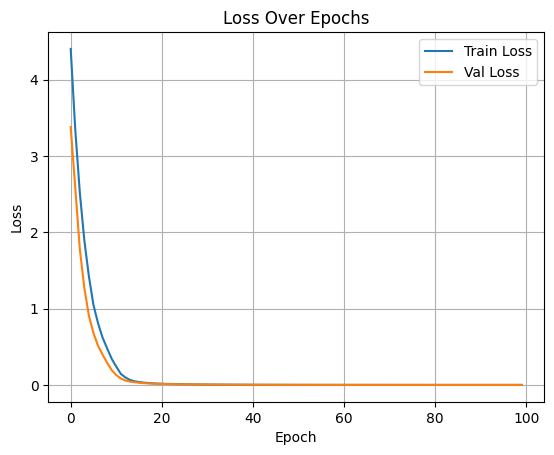

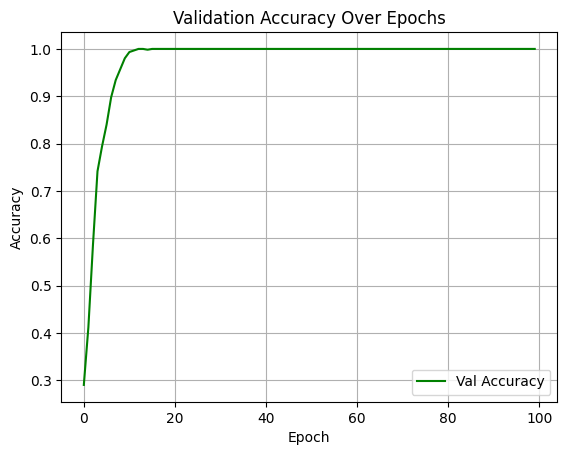


--- French to English Translation Examples ---
Il a faim → He is hungry
Elle parle français couramment → She speaks French fluently
Le soleil brille → The sun is shining

--- French to English Recombinations ---
Elle a faim → She is happy
Nous sommes fatigué → We are friends
Ils aiment la musique → They go shopping
Il parle français → He sings beautifully
Le chat est heureux → The cat is sleeping
Il étudie les mathématiques → He listens to music while jogging
Nous regardons des films ensemble → We watch movies on Fridays
Elle joue au football → She writes poetry in her free time


In [34]:
#Problem 3 w/out attention:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Vocabulary Class ---
class Vocabulary:
    def __init__(self):
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>"}
        self.word_count = {}
        self.n_words = 3

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word_count[word] = 1
            self.n_words += 1
        else:
            self.word_count[word] += 1

# --- Dataset and Tokenization ---
def tokenize_and_pad(sentences, vocab):
    max_length = max(len(sentence.split(' ')) for sentence in sentences) + 2
    tokenized = []
    for sentence in sentences:
        tokens = [vocab.word2index["<SOS>"]] + [vocab.word2index[word] for word in sentence.split(' ')] + [vocab.word2index["<EOS>"]]
        tokens += [vocab.word2index["<PAD>"]] * (max_length - len(tokens))
        tokenized.append(tokens)
    return torch.tensor(tokenized, dtype=torch.long)

class EngFrDataset(Dataset):
    def __init__(self, pairs):
        self.eng_vocab = Vocabulary()
        self.fr_vocab = Vocabulary()
        self.pairs = pairs

        for eng, fr in pairs:
            self.eng_vocab.add_sentence(eng)
            self.fr_vocab.add_sentence(fr)

        self.eng_sentences = [pair[0] for pair in pairs]
        self.fr_sentences = [pair[1] for pair in pairs]
        self.eng_tokens = tokenize_and_pad(self.eng_sentences, self.eng_vocab)
        self.fr_tokens = tokenize_and_pad(self.fr_sentences, self.fr_vocab)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.fr_tokens[idx], self.eng_tokens[idx]  # Reversed: French → English

# --- GRU Encoder and Decoder ---
class GRUEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        _, hidden = self.gru(embedded)
        return hidden

class GRUDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded, hidden)
        output = self.softmax(self.fc(output))
        return output, hidden

# --- Training Function ---
def train_model(encoder, decoder, dataloader, eng_vocab, n_epochs=20):
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
    criterion = nn.NLLLoss(ignore_index=eng_vocab.word2index["<PAD>"])

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(n_epochs):
        encoder.train()
        decoder.train()
        total_loss = 0

        for fr_tensor, eng_tensor in dataloader:
            fr_tensor, eng_tensor = fr_tensor.to(device), eng_tensor.to(device)
            encoder_hidden = encoder(fr_tensor)
            decoder_input = eng_tensor[:, :-1]
            decoder_target = eng_tensor[:, 1:]
            decoder_output, _ = decoder(decoder_input, encoder_hidden)

            loss = criterion(decoder_output.view(-1, decoder_output.size(-1)), decoder_target.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        val_loss, val_acc = evaluate_model(encoder, decoder, dataloader, eng_vocab, verbose=False)

        train_losses.append(avg_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, val_accuracies

# --- Evaluation Function ---
def evaluate_model(encoder, decoder, dataloader, eng_vocab, verbose=True):
    encoder.eval()
    decoder.eval()
    criterion = nn.NLLLoss(ignore_index=eng_vocab.word2index["<PAD>"])
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for fr_tensor, eng_tensor in dataloader:
            fr_tensor, eng_tensor = fr_tensor.to(device), eng_tensor.to(device)
            encoder_hidden = encoder(fr_tensor)
            decoder_input = eng_tensor[:, :-1]
            decoder_target = eng_tensor[:, 1:]
            decoder_output, _ = decoder(decoder_input, encoder_hidden)

            loss = criterion(decoder_output.view(-1, decoder_output.size(-1)), decoder_target.view(-1))
            total_loss += loss.item()

            predictions = decoder_output.argmax(dim=2)
            mask = decoder_target != eng_vocab.word2index["<PAD>"]
            correct += ((predictions == decoder_target) & mask).sum().item()
            total += mask.sum().item()

    val_loss = total_loss / len(dataloader)
    val_acc = correct / total
    if verbose:
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}")
    return val_loss, val_acc

# --- Translation ---
def translate(encoder, decoder, sentence, dataset):
    encoder.eval()
    decoder.eval()
    fr_vocab = dataset.fr_vocab
    eng_vocab = dataset.eng_vocab

    tokens = [fr_vocab.word2index.get("<SOS>", 1)] + [fr_vocab.word2index.get(word, 0) for word in sentence.split()] + [fr_vocab.word2index.get("<EOS>", 2)]
    input_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        hidden = encoder(input_tensor)
        decoder_input = torch.tensor([[eng_vocab.word2index["<SOS>"]]], device=device)
        decoded_words = []

        for _ in range(20):
            output, hidden = decoder(decoder_input, hidden)
            topv, topi = output.topk(1)
            next_word = topi[:, 0, 0].item()
            if next_word == eng_vocab.word2index["<EOS>"]:
                break
            decoded_words.append(eng_vocab.index2word[next_word])
            decoder_input = torch.tensor([[next_word]], device=device)

    return ' '.join(decoded_words)

# --- Dataset ---
english_to_french = [
    ("I am cold", "J'ai froid"),
    ("You are tired", "Tu es fatigué"),
    ("He is hungry", "Il a faim"),
    ("She is happy", "Elle est heureuse"),
    ("We are friends", "Nous sommes amis"),
    ("They are students", "Ils sont étudiants"),
    ("The cat is sleeping", "Le chat dort"),
    ("The sun is shining", "Le soleil brille"),
    ("We love music", "Nous aimons la musique"),
    ("She speaks French fluently", "Elle parle français couramment"),
("He enjoys reading books", "Il aime lire des livres"),
("They play soccer every weekend", "Ils jouent au football chaque week-end"),
("The movie starts at 7 PM", "Le film commence à 19 heures"),
("She wears a red dress", "Elle porte une robe rouge"),
("We cook dinner together", "Nous cuisinons le dîner ensemble"),
("He drives a blue car", "Il conduit une voiture bleue"),
("They visit museums often", "Ils visitent souvent des musées"),
("The restaurant serves delicious food", "Le restaurant sert une délicieuse cuisine"),
("She studies mathematics at university", "Elle étudie les mathématiques à l'université"),
("We watch movies on Fridays", "Nous regardons des films le vendredi"),
("He listens to music while jogging", "Il écoute de la musique en faisant du jogging"),
("They travel around the world", "Ils voyagent autour du monde"),
("The book is on the table", "Le livre est sur la table"),
("She dances gracefully", "Elle danse avec grâce"),
("We celebrate birthdays with cake", "Nous célébrons les anniversaires avec un gâteau"),
("He works hard every day", "Il travaille dur tous les jours"),
("They speak different languages", "Ils parlent différentes langues"),
("The flowers bloom in spring", "Les fleurs fleurissent au printemps"),
("She writes poetry in her free time", "Elle écrit de la poésie pendant son temps libre"),
("We learn something new every day", "Nous apprenons quelque chose de nouveau chaque jour"),
("The dog barks loudly", "Le chien aboie bruyamment"),
("He sings beautifully", "Il chante magnifiquement"),
("They swim in the pool", "Ils nagent dans la piscine"),
("The birds chirp in the morning", "Les oiseaux gazouillent le matin"),
("She teaches English at school", "Elle enseigne l'anglais à l'école"),
("We eat breakfast together", "Nous prenons le petit déjeuner ensemble"),
("He paints landscapes", "Il peint des paysages"),
("They laugh at the joke", "Ils rient de la blague"),
("The clock ticks loudly", "L'horloge tic-tac bruyamment"),
("She runs in the park", "Elle court dans le parc"),
("We travel by train", "Nous voyageons en train"),
("He writes a letter", "Il écrit une lettre"),
("They read books at the library", "Ils lisent des livres à la bibliothèque"),
("The baby cries", "Le bébé pleure"),
("She studies hard for exams", "Elle étudie dur pour les examens"),
("We plant flowers in the garden", "Nous plantons des fleurs dans le jardin"),
("He fixes the car", "Il répare la voiture"),
("They drink coffee in the morning", "Ils boivent du café le matin"),
("The sun sets in the evening", "Le soleil se couche le soir"),
("She dances at the party", "Elle danse à la fête"),
("We play music at the concert", "Nous jouons de la musique au concert"),
("He cooks dinner for his family", "Il cuisine le dîner pour sa famille"),
("They study French grammar", "Ils étudient la grammaire française"),
("The rain falls gently", "La pluie tombe doucement"),
("She sings a song", "Elle chante une chanson"),
("We watch a movie together", "Nous regardons un film ensemble"),
("He sleeps deeply", "Il dort profondément"),
("They travel to Paris", "Ils voyagent à Paris"),
("The children play in the park", "Les enfants jouent dans le parc"),
("She walks along the beach", "Elle se promène le long de la plage"),
("We talk on the phone", "Nous parlons au téléphone"),
("He waits for the bus", "Il attend le bus"),
("They visit the Eiffel Tower", "Ils visitent la tour Eiffel"),
("The stars twinkle at night", "Les étoiles scintillent la nuit"),
("She dreams of flying", "Elle rêve de voler"),
("We work in the office", "Nous travaillons au bureau"),
("He studies history", "Il étudie l'histoire"),
("They listen to the radio", "Ils écoutent la radio"),
("The wind blows gently", "Le vent souffle doucement"),
("She swims in the ocean", "Elle nage dans l'océan"),
("We dance at the wedding", "Nous dansons au mariage"),
("He climbs the mountain", "Il gravit la montagne"),
("They hike in the forest", "Ils font de la randonnée dans la forêt"),
("The cat meows loudly", "Le chat miaule bruyamment"),
("She paints a picture", "Elle peint un tableau"),
("We build a sandcastle", "Nous construisons un château de sable"),
("He sings in the choir", "Il chante dans le chœur"),
("They ride bicycles", "Ils font du vélo"),
("The coffee is hot", "Le café est chaud"),
("She wears glasses", "Elle porte des lunettes"),
("We visit our grandparents", "Nous rendons visite à nos grands-parents"),
("He plays the guitar", "Il joue de la guitare"),
("They go shopping", "Ils font du shopping"),
("The teacher explains the lesson", "Le professeur explique la leçon"),
("She takes the train to work", "Elle prend le train pour aller au travail"),
("We bake cookies", "Nous faisons des biscuits"),
("He washes his hands", "Il se lave les mains"),
("They enjoy the sunset", "Ils apprécient le coucher du soleil"),
("The river flows calmly", "La rivière coule calmement"),
("She feeds the cat", "Elle nourrit le chat"),
("We visit the museum", "Nous visitons le musée"),
("He fixes his bicycle", "Il répare son vélo"),
("They paint the walls", "Ils peignent les murs"),
("The baby sleeps peacefully", "Le bébé dort paisiblement"),
("She ties her shoelaces", "Elle attache ses lacets"),
("We climb the stairs", "Nous montons les escaliers"),
("He shaves in the morning", "Il se rase le matin"),
("They set the table", "Ils mettent la table"),
("The airplane takes off", "L'avion décolle"),
("She waters the plants", "Elle arrose les plantes"),
("We practice yoga", "Nous pratiquons le yoga"),
("He turns off the light", "Il éteint la lumière"),
("They play video games", "Ils jouent aux jeux vidéo"),
("The soup smells delicious", "La soupe sent délicieusement bon"),
("She locks the door", "Elle ferme la porte à clé"),
("We enjoy a picnic", "Nous profitons d'un pique-nique"),
("He checks his email", "Il vérifie ses emails"),
("They go to the gym", "Ils vont à la salle de sport"),
("The moon shines brightly", "La lune brille intensément"),
("She catches the bus", "Elle attrape le bus"),
("We greet our neighbors", "Nous saluons nos voisins"),
("He combs his hair", "Il se peigne les cheveux"),
("They wave goodbye", "Ils font un signe d'adieu")
]

# Build dataset
dataset = EngFrDataset(english_to_french)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Instantiate models for French -> English
encoder = GRUEncoder(input_dim=dataset.fr_vocab.n_words, emb_dim=100, hid_dim=256).to(device)
decoder = GRUDecoder(output_dim=dataset.eng_vocab.n_words, emb_dim=100, hid_dim=256).to(device)

# Train the model
train_losses, val_losses, val_accuracies = train_model(encoder, decoder, dataloader, dataset.eng_vocab, n_epochs=100)

# Plot Loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure()
plt.plot(val_accuracies, label='Val Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

# --- Translate ---
examples = [
    "Il a faim",
    "Elle parle français couramment",
    "Le soleil brille"
]

print("\n--- French to English Translation Examples ---")
for sent in examples:
    print(f"{sent} → {translate(encoder, decoder, sent, dataset)}")

recombinations = [
    "Elle a faim",
    "Nous sommes fatigué",
    "Ils aiment la musique",
    "Il parle français",
    "Le chat est heureux",
    "Il étudie les mathématiques",
    "Nous regardons des films ensemble",
    "Elle joue au football"
]

print("\n--- French to English Recombinations ---")
for sent in recombinations:
    print(f"{sent} → {translate(encoder, decoder, sent, dataset)}")


Epoch 1, Train Loss: 4.2682, Val Loss: 3.6180, Val Accuracy: 0.2998
Epoch 2, Train Loss: 3.5002, Val Loss: 2.8919, Val Accuracy: 0.3591
Epoch 3, Train Loss: 2.8481, Val Loss: 2.1714, Val Accuracy: 0.4843
Epoch 4, Train Loss: 2.2341, Val Loss: 1.5593, Val Accuracy: 0.6277
Epoch 5, Train Loss: 1.7021, Val Loss: 1.0328, Val Accuracy: 0.8122
Epoch 6, Train Loss: 1.1905, Val Loss: 0.6457, Val Accuracy: 0.8830
Epoch 7, Train Loss: 0.7793, Val Loss: 0.4391, Val Accuracy: 0.9374
Epoch 8, Train Loss: 0.5246, Val Loss: 0.2995, Val Accuracy: 0.9703
Epoch 9, Train Loss: 0.3463, Val Loss: 0.1758, Val Accuracy: 0.9901
Epoch 10, Train Loss: 0.2216, Val Loss: 0.1029, Val Accuracy: 0.9967
Epoch 11, Train Loss: 0.1226, Val Loss: 0.0651, Val Accuracy: 0.9967
Epoch 12, Train Loss: 0.0746, Val Loss: 0.0470, Val Accuracy: 0.9984
Epoch 13, Train Loss: 0.0553, Val Loss: 0.0348, Val Accuracy: 1.0000
Epoch 14, Train Loss: 0.0399, Val Loss: 0.0272, Val Accuracy: 1.0000
Epoch 15, Train Loss: 0.0309, Val Loss: 0.0

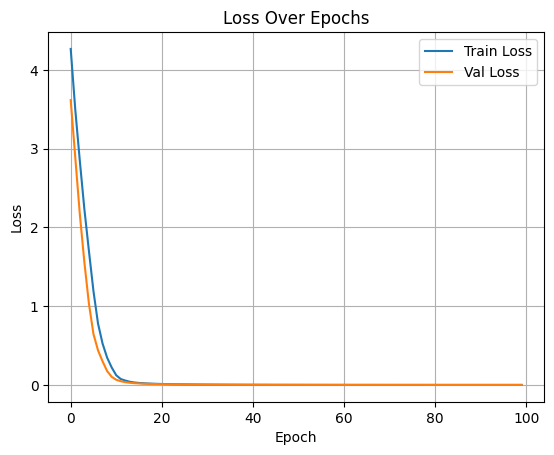

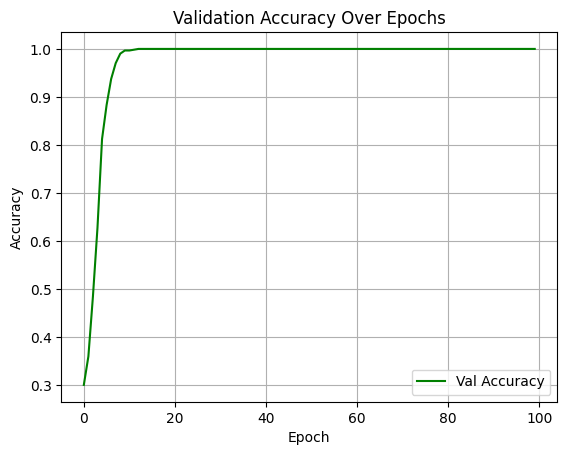


--- Known French Sentences ---
Il a faim -> He listens to music while jogging
Elle parle français couramment -> She speaks French fluently
Le soleil brille -> The sun sets in the evening

--- Recombinations ---
Elle est heureuse -> She takes the door
Nous sommes amis -> We learn something new every day
Tu es fatigué -> You are tired
Le chat dort -> The restaurant serves delicious food
J'ai froid -> I am hard every day


In [31]:
#Problem 3 w/ attention:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Vocabulary ---
class Vocabulary:
    def __init__(self):
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>"}
        self.word_count = {}
        self.n_words = 3

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word_count[word] = 1
            self.n_words += 1
        else:
            self.word_count[word] += 1

# --- Tokenization ---
def tokenize_and_pad(sentences, vocab):
    max_length = max(len(sentence.split(' ')) for sentence in sentences) + 2
    tokenized = []
    for sentence in sentences:
        tokens = [vocab.word2index["<SOS>"]] + [vocab.word2index[word] for word in sentence.split(' ')] + [vocab.word2index["<EOS>"]]
        tokens += [vocab.word2index["<PAD>"]] * (max_length - len(tokens))
        tokenized.append(tokens)
    return torch.tensor(tokenized, dtype=torch.long)

# --- Dataset ---
class EngFrDataset(Dataset):
    def __init__(self, pairs):
        self.eng_vocab = Vocabulary()
        self.fr_vocab = Vocabulary()
        self.pairs = pairs

        for eng, fr in pairs:
            self.eng_vocab.add_sentence(eng)
            self.fr_vocab.add_sentence(fr)

        self.fr_sentences = [pair[1] for pair in pairs]  # input now French
        self.eng_sentences = [pair[0] for pair in pairs]  # target now English
        self.fr_tokens = tokenize_and_pad(self.fr_sentences, self.fr_vocab)
        self.eng_tokens = tokenize_and_pad(self.eng_sentences, self.eng_vocab)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.fr_tokens[idx], self.eng_tokens[idx]

# --- Encoder ---
class GRUEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden

# --- Attention Decoder ---
class AttnDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout_p=0.1):
        super(AttnDecoder, self).__init__()
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.attn = nn.Linear(hid_dim + emb_dim, hid_dim)
        self.v = nn.Parameter(torch.rand(hid_dim))
        self.attn_combine = nn.Linear(hid_dim + emb_dim, hid_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hid_dim, hid_dim)
        self.out = nn.Linear(hid_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)  # [B, 1, E]
        embedded = self.dropout(embedded)

        batch_size = encoder_outputs.size(0)
        seq_len = encoder_outputs.size(1)

        hidden_trans = hidden.transpose(0, 1)  # [B, 1, H]
        hidden_repeat = hidden_trans.repeat(1, seq_len, 1)
        embedded_repeat = embedded.repeat(1, seq_len, 1)

        attn_input = torch.cat((embedded_repeat, hidden_repeat), dim=2)
        energy = torch.tanh(self.attn(attn_input))
        energy = torch.sum(self.v * energy, dim=2)
        attn_weights = torch.softmax(energy, dim=1)

        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        rnn_input = torch.cat((embedded, context), dim=2)
        rnn_input = torch.relu(self.attn_combine(rnn_input))

        output, hidden = self.gru(rnn_input, hidden)
        output = torch.log_softmax(self.out(output), dim=2)
        return output, hidden

# --- Training ---
def train_model(encoder, decoder, dataloader, eng_vocab, n_epochs=20):
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
    criterion = nn.NLLLoss(ignore_index=eng_vocab.word2index["<PAD>"])
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(n_epochs):
        encoder.train()
        decoder.train()
        total_loss = 0

        for fr_tensor, eng_tensor in dataloader:
            fr_tensor, eng_tensor = fr_tensor.to(device), eng_tensor.to(device)
            encoder_outputs, encoder_hidden = encoder(fr_tensor)
            decoder_input = eng_tensor[:, :-1]
            decoder_target = eng_tensor[:, 1:]

            decoder_outputs = []
            decoder_hidden = encoder_hidden

            for t in range(decoder_input.size(1)):
                output, decoder_hidden = decoder(decoder_input[:, t].unsqueeze(1), decoder_hidden, encoder_outputs)
                decoder_outputs.append(output)

            decoder_outputs = torch.cat(decoder_outputs, dim=1)
            loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), decoder_target.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        val_loss, val_acc = evaluate_model(encoder, decoder, dataloader, eng_vocab, verbose=False)
        train_losses.append(avg_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    return train_losses, val_losses, val_accuracies

# --- Evaluation ---
def evaluate_model(encoder, decoder, dataloader, eng_vocab, verbose=True):
    encoder.eval()
    decoder.eval()
    criterion = nn.NLLLoss(ignore_index=eng_vocab.word2index["<PAD>"])
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for fr_tensor, eng_tensor in dataloader:
            fr_tensor, eng_tensor = fr_tensor.to(device), eng_tensor.to(device)
            encoder_outputs, encoder_hidden = encoder(fr_tensor)
            decoder_input = eng_tensor[:, :-1]
            decoder_target = eng_tensor[:, 1:]

            decoder_outputs = []
            decoder_hidden = encoder_hidden

            for t in range(decoder_input.size(1)):
                output, decoder_hidden = decoder(decoder_input[:, t].unsqueeze(1), decoder_hidden, encoder_outputs)
                decoder_outputs.append(output)

            decoder_outputs = torch.cat(decoder_outputs, dim=1)
            loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), decoder_target.view(-1))
            total_loss += loss.item()

            predictions = decoder_outputs.argmax(dim=2)
            mask = decoder_target != eng_vocab.word2index["<PAD>"]
            correct += ((predictions == decoder_target) & mask).sum().item()
            total += mask.sum().item()

    val_loss = total_loss / len(dataloader)
    val_acc = correct / total
    if verbose:
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}")
    return val_loss, val_acc

# --- Translation ---
def translate(encoder, decoder, sentence, dataset):
    encoder.eval()
    decoder.eval()
    fr_vocab = dataset.fr_vocab
    eng_vocab = dataset.eng_vocab
    tokens = [fr_vocab.word2index.get("<SOS>", 1)] + [fr_vocab.word2index.get(word, 0) for word in sentence.split()] + [fr_vocab.word2index.get("<EOS>", 2)]
    input_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_input = torch.tensor([[eng_vocab.word2index["<SOS>"]]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []

        for _ in range(20):
            output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = output.topk(1)
            next_word = topi[:, 0, 0].item()
            if next_word == eng_vocab.word2index["<EOS>"]:
                break
            decoded_words.append(eng_vocab.index2word[next_word])
            decoder_input = torch.tensor([[next_word]], device=device)

    return ' '.join(decoded_words)

# --- Dataset ---
english_to_french = [
    ("I am cold", "J'ai froid"),
    ("You are tired", "Tu es fatigué"),
    ("He is hungry", "Il a faim"),
    ("She is happy", "Elle est heureuse"),
    ("We are friends", "Nous sommes amis"),
    ("They are students", "Ils sont étudiants"),
    ("The cat is sleeping", "Le chat dort"),
    ("The sun is shining", "Le soleil brille"),
    ("We love music", "Nous aimons la musique"),
    ("She speaks French fluently", "Elle parle français couramment"),
("He enjoys reading books", "Il aime lire des livres"),
("They play soccer every weekend", "Ils jouent au football chaque week-end"),
("The movie starts at 7 PM", "Le film commence à 19 heures"),
("She wears a red dress", "Elle porte une robe rouge"),
("We cook dinner together", "Nous cuisinons le dîner ensemble"),
("He drives a blue car", "Il conduit une voiture bleue"),
("They visit museums often", "Ils visitent souvent des musées"),
("The restaurant serves delicious food", "Le restaurant sert une délicieuse cuisine"),
("She studies mathematics at university", "Elle étudie les mathématiques à l'université"),
("We watch movies on Fridays", "Nous regardons des films le vendredi"),
("He listens to music while jogging", "Il écoute de la musique en faisant du jogging"),
("They travel around the world", "Ils voyagent autour du monde"),
("The book is on the table", "Le livre est sur la table"),
("She dances gracefully", "Elle danse avec grâce"),
("We celebrate birthdays with cake", "Nous célébrons les anniversaires avec un gâteau"),
("He works hard every day", "Il travaille dur tous les jours"),
("They speak different languages", "Ils parlent différentes langues"),
("The flowers bloom in spring", "Les fleurs fleurissent au printemps"),
("She writes poetry in her free time", "Elle écrit de la poésie pendant son temps libre"),
("We learn something new every day", "Nous apprenons quelque chose de nouveau chaque jour"),
("The dog barks loudly", "Le chien aboie bruyamment"),
("He sings beautifully", "Il chante magnifiquement"),
("They swim in the pool", "Ils nagent dans la piscine"),
("The birds chirp in the morning", "Les oiseaux gazouillent le matin"),
("She teaches English at school", "Elle enseigne l'anglais à l'école"),
("We eat breakfast together", "Nous prenons le petit déjeuner ensemble"),
("He paints landscapes", "Il peint des paysages"),
("They laugh at the joke", "Ils rient de la blague"),
("The clock ticks loudly", "L'horloge tic-tac bruyamment"),
("She runs in the park", "Elle court dans le parc"),
("We travel by train", "Nous voyageons en train"),
("He writes a letter", "Il écrit une lettre"),
("They read books at the library", "Ils lisent des livres à la bibliothèque"),
("The baby cries", "Le bébé pleure"),
("She studies hard for exams", "Elle étudie dur pour les examens"),
("We plant flowers in the garden", "Nous plantons des fleurs dans le jardin"),
("He fixes the car", "Il répare la voiture"),
("They drink coffee in the morning", "Ils boivent du café le matin"),
("The sun sets in the evening", "Le soleil se couche le soir"),
("She dances at the party", "Elle danse à la fête"),
("We play music at the concert", "Nous jouons de la musique au concert"),
("He cooks dinner for his family", "Il cuisine le dîner pour sa famille"),
("They study French grammar", "Ils étudient la grammaire française"),
("The rain falls gently", "La pluie tombe doucement"),
("She sings a song", "Elle chante une chanson"),
("We watch a movie together", "Nous regardons un film ensemble"),
("He sleeps deeply", "Il dort profondément"),
("They travel to Paris", "Ils voyagent à Paris"),
("The children play in the park", "Les enfants jouent dans le parc"),
("She walks along the beach", "Elle se promène le long de la plage"),
("We talk on the phone", "Nous parlons au téléphone"),
("He waits for the bus", "Il attend le bus"),
("They visit the Eiffel Tower", "Ils visitent la tour Eiffel"),
("The stars twinkle at night", "Les étoiles scintillent la nuit"),
("She dreams of flying", "Elle rêve de voler"),
("We work in the office", "Nous travaillons au bureau"),
("He studies history", "Il étudie l'histoire"),
("They listen to the radio", "Ils écoutent la radio"),
("The wind blows gently", "Le vent souffle doucement"),
("She swims in the ocean", "Elle nage dans l'océan"),
("We dance at the wedding", "Nous dansons au mariage"),
("He climbs the mountain", "Il gravit la montagne"),
("They hike in the forest", "Ils font de la randonnée dans la forêt"),
("The cat meows loudly", "Le chat miaule bruyamment"),
("She paints a picture", "Elle peint un tableau"),
("We build a sandcastle", "Nous construisons un château de sable"),
("He sings in the choir", "Il chante dans le chœur"),
("They ride bicycles", "Ils font du vélo"),
("The coffee is hot", "Le café est chaud"),
("She wears glasses", "Elle porte des lunettes"),
("We visit our grandparents", "Nous rendons visite à nos grands-parents"),
("He plays the guitar", "Il joue de la guitare"),
("They go shopping", "Ils font du shopping"),
("The teacher explains the lesson", "Le professeur explique la leçon"),
("She takes the train to work", "Elle prend le train pour aller au travail"),
("We bake cookies", "Nous faisons des biscuits"),
("He washes his hands", "Il se lave les mains"),
("They enjoy the sunset", "Ils apprécient le coucher du soleil"),
("The river flows calmly", "La rivière coule calmement"),
("She feeds the cat", "Elle nourrit le chat"),
("We visit the museum", "Nous visitons le musée"),
("He fixes his bicycle", "Il répare son vélo"),
("They paint the walls", "Ils peignent les murs"),
("The baby sleeps peacefully", "Le bébé dort paisiblement"),
("She ties her shoelaces", "Elle attache ses lacets"),
("We climb the stairs", "Nous montons les escaliers"),
("He shaves in the morning", "Il se rase le matin"),
("They set the table", "Ils mettent la table"),
("The airplane takes off", "L'avion décolle"),
("She waters the plants", "Elle arrose les plantes"),
("We practice yoga", "Nous pratiquons le yoga"),
("He turns off the light", "Il éteint la lumière"),
("They play video games", "Ils jouent aux jeux vidéo"),
("The soup smells delicious", "La soupe sent délicieusement bon"),
("She locks the door", "Elle ferme la porte à clé"),
("We enjoy a picnic", "Nous profitons d'un pique-nique"),
("He checks his email", "Il vérifie ses emails"),
("They go to the gym", "Ils vont à la salle de sport"),
("The moon shines brightly", "La lune brille intensément"),
("She catches the bus", "Elle attrape le bus"),
("We greet our neighbors", "Nous saluons nos voisins"),
("He combs his hair", "Il se peigne les cheveux"),
("They wave goodbye", "Ils font un signe d'adieu")
]

# --- Setup ---
dataset = EngFrDataset(english_to_french)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
encoder = GRUEncoder(input_dim=dataset.fr_vocab.n_words, emb_dim=100, hid_dim=256).to(device)
decoder = AttnDecoder(output_dim=dataset.eng_vocab.n_words, emb_dim=100, hid_dim=256).to(device)

# --- Train ---
train_losses, val_losses, val_accuracies = train_model(encoder, decoder, dataloader, dataset.eng_vocab, n_epochs=100)

# --- Plot ---
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(val_accuracies, label='Val Accuracy', color='green')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# --- Test: French → English ---
print("\n--- Known French Sentences ---")
examples = ["Il a faim", "Elle parle français couramment", "Le soleil brille"]
for sent in examples:
    print(f"{sent} -> {translate(encoder, decoder, sent, dataset)}")

print("\n--- Recombinations ---")
recombinations = [
    "Elle est heureuse",
    "Nous sommes amis",
    "Tu es fatigué",
    "Le chat dort",
    "J'ai froid"
]
for sent in recombinations:
    print(f"{sent} -> {translate(encoder, decoder, sent, dataset)}")
